### Juliaの計算は関数にしようって話

項目反応理論 (IRT) モデルのパラメタ推定には潜在変数 (latent variable, hidden valiable) が含まれるため，それを周辺化して構造母数だけを推定するのがお作法。

潜在変数を周辺化しながら最大化を図るための効率よいアルゴリズムにEMアルゴリズムと呼ばれるものがある。ところが困ったことにIRTモデルの尤度関数の潜在変数についての積分は解析的に解くことができない。

そこで区分求積法に頼って近似計算をするわけだが，これが結構計算コストがかかる。R単体でfor loopを回すと，めっちゃおそい。

普通はここでC++などの力を借りて高速化計算するのだが，今回はJuliaでお手軽高速化を図ってみたい。まだRとJuliaのIntegrationはよく分からないので，こんかいはJulia単体でいく。

プロットに使うパラメタと関数の定義

In [1]:
using Distributions, Random, StatsFuns, Plots

In [2]:
function icc2pl(θ::Float64, α::Float64, β::Float64)::Float64
    x::Float64 = α * (θ - β)
    p::Float64 = StatsFuns.logistic(x)
    p
end

icc2pl (generic function with 1 method)

もっと賢い書き方もある気がするけど，とりあえず愚直にforを回す。

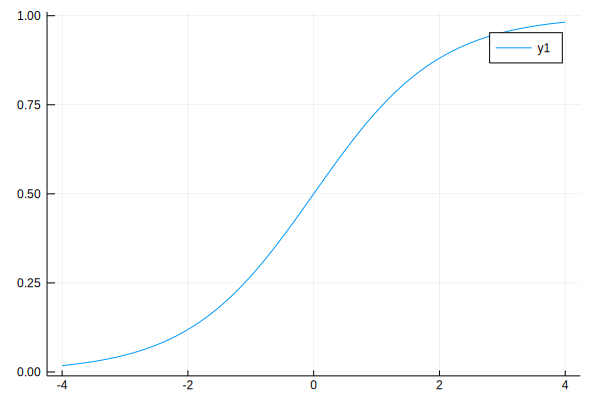

In [3]:
theta = collect(-4:0.1:4)
icc = zeros(length(theta))
for i in 1:length(theta)
    icc[i] = icc2pl(theta[i], 1.0, 0.0)
end
plot(theta, icc)

ｘ軸が右に行けば行くほど，ある問題への正答確率が高くなる様なモデルを考える。このときαは項目が持つ能力の識別性能の高さを，βは項目自体の難しさを表していると考える。ここら辺は項目反応理論でググってみてください。今回は割愛します。

In [40]:
struct simgenClass2
    resp::Array{Int64,2}
    θ::Array{Float64,1}
    α::Array{Float64,1}
    β::Array{Float64,1}
end

function resgen_bin(N::Int, J::Int)
    θ = rand(Normal(), N)
    α = rand(LogNormal(), J)
    β = rand(Normal(-1, 1), J)
    resp = zeros(Int64, length(θ), length(α))
    for i in 1:length(θ)
        for j in 1:length(α)
            resp[i, j] = ifelse(rand() > icc2pl(θ[i], α[j], β[j]), 0, 1)
        end
    end
    simgenClass2(resp, θ, α, β)
end

resgen_bin (generic function with 1 method)

擬似的な項目反応データを生成する。50000人分のデータを生成するのだが，ここの時点ですでに高速すぎてちびった。

In [43]:
N = 50_000
J = 50
@time resgen_bin(N, J)

  0.058579 seconds (2.76 k allocations: 19.498 MiB)


simgenClass2([1 0 … 1 1; 1 1 … 1 0; … ; 1 0 … 1 1; 1 1 … 1 1], [0.16099, -0.678808, 0.457395, 0.453073, 0.310874, -0.822951, 0.271002, -0.147871, -0.999116, -0.363523  …  -0.105797, -0.830859, -1.21541, 0.845631, 1.39459, 1.44449, -0.388785, -0.618865, -0.943425, -1.17293], [0.54494, 1.71906, 1.12542, 0.595063, 1.03782, 0.489053, 2.05296, 0.37631, 2.78794, 1.79084  …  2.1822, 0.694498, 1.18709, 0.946057, 6.65905, 3.11907, 0.286872, 1.02368, 1.53182, 0.488699], [-3.1403, -0.49488, 0.362954, -1.3816, -0.371558, -2.09085, -0.268813, -0.417073, -0.937248, 0.857298  …  -1.16759, -2.57849, -0.454556, -1.75791, -1.05828, 0.40001, -0.331622, -1.17879, -1.81634, -1.33322])

尤度関数の周辺化を数値的に近似するための関数。

In [44]:
struct EstepClass2
    resp::Array{Int64,2}
    θ::Array{Float64,1}
    α::Array{Float64,1}
    β::Array{Float64,1}
    Gim::Array{Float64,2}
    Lim::Array{Float64,2}
end

function Estep(N::Int, J::Int, M::Int)
    by = (4-(-4))/M
    xq = collect(-4:by:4)
    aq = pdf.(Normal(), xq) ./ sum(pdf.(Normal(), xq))
    L = zeros(N, length(xq))
    Gim = zeros(N, length(xq))
    # sim data gen
    resp = resgen_bin(N, J)
    x = resp.resp
    α = resp.α
    β = resp.β
    for m in 1:M
        println("NOW...", m)
        for i in 1:N
            Li = zeros(J)
            for j in 1:J
                Li[j] = ifelse(x[i, j] == 1, icc2pl(xq[m], α[j], β[j]), 1 - icc2pl(xq[m], α[j], β[j]))
            end
            L[i, m] = prod(Li)
            Gim[i,m] = L[i,m] * aq[m]
        end
        if(m == length(xq))
            for i in 1:N
                Gim[i,m] = Gim[i,m]/sum(Gim[i,:])
            end
        end
    end
    EstepClass2(x, θ, α, β, Gim, L)
end

Estep (generic function with 1 method)

In [36]:
@time Estep(50000, 50, 30)

NOW...1
NOW...2
NOW...3
NOW...4
NOW...5
NOW...6
NOW...7
NOW...8
NOW...9
NOW...10
NOW...11
NOW...12
NOW...13
NOW...14
NOW...15
NOW...16
NOW...17
NOW...18
NOW...19
NOW...20
NOW...21
NOW...22
NOW...23
NOW...24
NOW...25
NOW...26
NOW...27
NOW...28
NOW...29
NOW...30
  2.762779 seconds (1.63 M allocations: 758.630 MiB, 5.04% gc time)


EstepClass2([1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], [-0.37216, 0.394744, 1.0254, 0.0571423, 0.80871, 1.02205, -0.383376, 0.114626, -1.59855, 0.249076  …  -0.107049, -0.35597, -0.0211458, 0.996935, -0.308854, 0.345422, 0.31834, 0.709949, -2.01223, 0.0424107], [1.48159, 0.932297, 0.811575, 1.59753, 0.855244, 4.2433, 4.43223, 0.439847, 0.461096, 0.905005  …  0.844219, 0.930126, 1.04635, 0.751366, 2.10459, 13.2816, 0.122729, 0.491111, 0.493516, 1.50265], [-1.54179, -1.3377, -1.79193, -1.00404, -1.69861, -0.991398, -1.41818, -1.01052, -0.331266, -1.77651  …  -1.16776, -3.63493, -1.86877, -0.332499, -0.855854, -0.140566, -2.58158, -2.59735, -1.43972, -2.08783], [2.99803e-119 4.0408e-110 … 6.50739e-14 0.0; 1.32238e-122 3.53826e-113 … 1.24229e-8 0.0; … ; 2.26314e-115 1.33017e-106 … 1.73261e-20 0.0; 2.79725e-57 3.96453e-52 … 0.0 0.0], [8.40037e-115 4.0376e-106 … 6.50224e-10 0.0; 3.70526e-118 3.53546e-109 … 0.00012413 0.0; … ; 6.34123e-111 1.32912e-102 … 1.73124e-16 0.0; 7.8378e-53 3.9

今度は関数化しないバージョン。最初にこちらのバージョンを走らせていて，「Juliaたいしたことねーな。」とか思っていたことは秘密。

In [39]:
N = 50_000
J = 50
M = 30
by = (4-(-4))/M
xq = collect(-4:by:4)
aq = pdf.(Normal(), xq) ./ sum(pdf.(Normal(), xq))
L = zeros(N, length(xq))
Gim = zeros(N, length(xq))
# sim data gen
resp = resgen_bin(N, J)
x = resp.resp
α = resp.α
β = resp.β
@time for m in 1:M
    println("NOW...", m)
    for i in 1:N
        Li = zeros(J)
        for j in 1:J
            Li[j] = ifelse(x[i, j] == 1, icc2pl(xq[m], α[j], β[j]), 1 - icc2pl(xq[m], α[j], β[j]))
        end
        L[i, m] = prod(Li)
        Gim[i,m] = L[i,m] * aq[m]
    end
    if(m == length(xq))
        for i in 1:N
            Gim[i,m] = Gim[i,m]/sum(Gim[i,:])
        end
    end
end

NOW...1
NOW...2
NOW...3
NOW...4
NOW...5
NOW...6
NOW...7
NOW...8
NOW...9
NOW...10
NOW...11
NOW...12
NOW...13
NOW...14
NOW...15
NOW...16
NOW...17
NOW...18
NOW...19
NOW...20
NOW...21
NOW...22
NOW...23
NOW...24
NOW...25
NOW...26
NOW...27
NOW...28
NOW...29
NOW...30
 23.034723 seconds (613.47 M allocations: 10.975 GiB, 4.70% gc time)


以上，Juliaでfor loopをいっぱい回すときは，関数にすることを心がけましょう。